In [1]:
import pooch

# don't have pooch output messages about downloading or untarring
logger = pooch.get_logger()
logger.setLevel("WARNING")

:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`ps_limitations.ipynb`**!

:::

(ps-limitations)=
# Portilla-Simoncelli Model Limitations

Not all texture model metamers look perceptually similar to humans. {cite:alp}`Portilla2000-param-textur` figures 17 and 18 present two classes of failures: "inhomogeneous texture images not usually considered to be 'texture'" (such as human faces, fig. 17) and some simple hand-drawn textures (fig. 18), many of which are simple geometric line drawings.

Note that for these examples, we were unable to locate the original images, so we present examples that serve the same purpose.

In [2]:
import matplotlib.pyplot as plt
import torch

import plenoptic as po

%load_ext autoreload
%autoreload 2

# We need to download some additional images for this notebook. In order to do so,
# we use an optional dependency, pooch. If the following raises an ImportError or
# ModuleNotFoundError
# then install pooch in your plenoptic environment and restart your kernel.
from plenoptic.data.fetch import fetch_data

IMG_PATH = fetch_data("portilla_simoncelli_images.tar.gz")
CACHE_DIR = fetch_data("ps_regression.tar.gz")
# use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

# set seed for reproducibility
po.tools.set_seed(1)

:::{attention}
This notebook contains some metamers and, while any one synthesis operation does not take too long, all of them combined result in a lengthy notebook. Therefore, we have cached the result of most of these syntheses online and only download them for investigation in this notebook.

Additionally, while you can normally call {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` again to pick up where we left out, the cached version of the results discarded the optimizer's state dict (to reduce the size on disk). Thus, calling `met.synthesize(100)` with one of our cached and loaded metamer objects **will not** give the same result as calling `met.synthesize(200)` with a new metamer object initialized as shown in this notebook.

:::

In [3]:
img = po.data.einstein().to(DEVICE).to(torch.float64)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
loss = po.tools.optim.portilla_simoncelli_loss_factory(model, img)
# to avoid running so many syntheses in this notebook, we load a cached version. see the
# following admonition for how to run this yourself
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / "ps_basic_synthesis_einstein.pt", map_location=DEVICE)

/home/agent/workspace/neurorse_plenoptic_PR-381@3/lib/python3.11/site-packages/plenoptic/synthesize/synthesis.py:390: UserWarning: You will need to call setup() to instantiate optimizer
  warnings.warn(


:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met.synthesize(max_iter=n_iters)
```
:::

Here we can see that the texture model fails to capture anything that makes this image look "portrait-like": there is no recognizable face or clothes in the synthesized metamer. As a portrait is generally not considered a texture, this is not a model *failure* per se, but does demonstrate the limits of this model.

:::{admonition} Portilla-Simoncelli metamers with **non-texture** targets
:class: warning

When synthesizing Portilla-Simoncelli metamers for texture target images (e.g., as in [](ps-examples)), we have a pretty good sense of what successful metamer synthesis should look like perceptually: a natural image that belongs to the same texture class as the target, which is not identical to the original image.

However, the above demonstrates that it is difficult to predict what a Portilla-Simoncelli metamer will look like for a **non-texture** target image. Therefore, one must be careful to ensure that their optimization procedure has converged to a low enough loss to be interpretable and that optimization has not failed because e.g., it got stuck in a local minimum. See [](ps-optimization) for further discussion.

:::

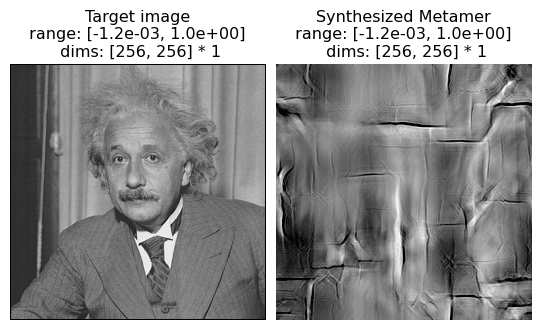

In [4]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized Metamer"],
    vrange="auto1",
);

In this example, we see the model metamer fails to reproduce the randomly distributed oriented black lines on a white background: in particular, several lines are curved and several appear discontinuous. From the paper: "Although a texture of single-orientation bars is reproduced fairly well (see Fig. 12), the mixture of bar orientations in this example leads to the synthesis of curved line segments. In general, the model is unable to distinguish straight from curved contours, except when the contours are all of the same orientation."

In [5]:
img = po.tools.load_images(IMG_PATH / "fig18a.png")
img = img.to(DEVICE).to(torch.float64)

# reuse the model and loss from above, only the image has changed.
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / "ps_basic_synthesis_fig18a.pt", map_location=DEVICE)

/home/agent/workspace/neurorse_plenoptic_PR-381@3/lib/python3.11/site-packages/plenoptic/synthesize/synthesis.py:390: UserWarning: You will need to call setup() to instantiate optimizer
  warnings.warn(


:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met.synthesize(max_iter=n_iters)
```
:::

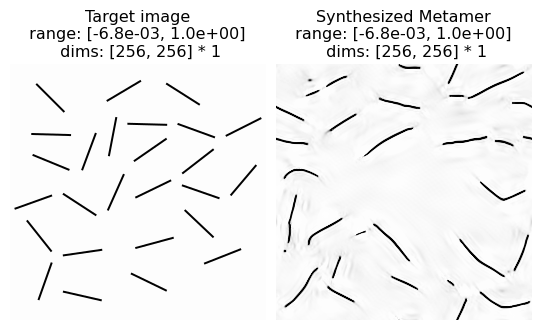

In [6]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized Metamer"],
    vrange="auto1",
);